<p style="color: pink; font-size: 30px; text-align: center;"><b>Scraping fragrance data using Selenium</b></p>
<p style="font-size: 20px; text-align: center;">Webscraping and Social Media Scraping</p>
<p style="font-size: 20px; text-align: center;">Lecturers: Maciej Świtała, Ewa Weychert</p>
<p style="font-size: 20px; text-align: center;">University of Warsaw, Spring 2025</p>


**Motivation**

The project explores the domain of perfumes as the main topic for web scraping and data analysis. Perfumes were chosen because of their complexity and richness in attributes, including scent notes, pricing strategies, and customer feedback, which makes them particularly suitable for analysis.

**Data**

A UK-based cosmetics website (https://www.parfumdreams.co.uk/) was selected as the data source. The focus was placed on the "Fragrances → Women’s Fragrances" section, which provided detailed product information. Individual product pages contained data such as perfume names, prices by volume, discounts, product images, scent descriptions, and fragrance notes (head, heart, and base). This level of detail made the website an appropriate choice, provided that all legal and ethical requirements were satisfied.

**Scrape legally**

The website’s robots.txt file (https://www.parfumdreams.co.uk/robots.txt) was reviewed to ensure compliance with scraping rules. According to its contents, scraping product and category pages without query parameters is permitted, while scraping pages with query parameters, order history, or CHANEL-specific search pages is disallowed. Additional checks of the website’s legal sections, including General Terms and Conditions, Legal Information, and Data Protection, confirmed that collecting factual, publicly available product data for non-commercial, academic purposes is acceptable:

- General Terms and Condition (https://www.parfumdreams.co.uk/General-Terms-and-Conditions-and-customer-information): there is no explicit clause that directly prohibits web scraping or automated data collection.
- Legal information (https://www.parfumdreams.co.uk/legal-information): Scraping factual product data (like name, price, volume, and fragrance notes) from parfumdreams.co.uk for a non-commercial is generally acceptable. However, using copyrighted content such as product images, detailed descriptions, or brand elements for commercial use or public sharing is not allowed without permission.
- Data protection (https://www.parfumdreams.co.uk/Data-Protection): The Data Protection Statement mainly governs personal user data, so factual, public product information that isn't tied to individuals is generally outside its scope. 

According to the available content, scraping for non-commercial, academic purposes is not restricted — which aligns with the scope of the project.

**Tools & Frameworks**

The data collection was carried out using Selenium. Selenium enabled the extension of data collection to approximately 90 products across the first four product-listing pages.

**Challenges**

1. Handling the Cookie Consent Shadow DOM. One challenge was interacting with a cookie consent popup, specifically the "Deny All" button, which was hidden inside a shadow DOM. This required accessing the shadow root and locating the button within it.

2. Dynamic Banners and Conditional Elements. Another challenge involved handling banners that appeared inconsistently on product detail pages, which changed the DOM structure and affected XPath references for scraping product details. Logic was introduced to detect the presence of optional elements (e.g., banners, discount images) and adjust the scraping process accordingly, ensuring resilience and adaptability to varying page layouts.

In [108]:
# !pip install selenium
# pip install webdriver_manager

In [109]:
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver import ActionChains
import pandas as pd
import os
import time
import warnings


driver = webdriver.Chrome()


url = 'https://www.parfumdreams.co.uk/'

driver.maximize_window() 
driver.get(url)

In [110]:
# Clicking deny button on the cookies window
deny_button_css_selector = "button[data-testid='uc-deny-all-button']"

try:
    shadow_host = WebDriverWait(driver, 5).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, 'div#usercentrics-root'))
    )
    
    shadow_root = driver.execute_script('return arguments[0].shadowRoot', shadow_host)
    
    deny_button = WebDriverWait(shadow_root, 5).until(
        EC.element_to_be_clickable((By.CSS_SELECTOR, deny_button_css_selector))
    )

    deny_button.click()
except Exception as e:
    print(f'Error while pushing the deny cookies button: {e}')

In [111]:
# Proceed to the page with list of perfumes
fragrance_el = driver.find_element(By.XPATH,"//a[@id='category_4']")
w_frangrances_id = "category_4_0"

try:
    hover = ActionChains(driver)
    hover_banner = hover.move_to_element(fragrance_el).perform()
    WebDriverWait(driver, 5).until(EC.element_to_be_clickable((By.ID, w_frangrances_id))).click()
except Exception as e:
    print(f'Error while hovering and clicking the link: {e}')

In [112]:
# Collect list of the links to parfume detail page
products_urls = list()
i = 0 
next_page_id = "nextPage"
page_count = 1
hover = ActionChains(driver)

while (i < 30) and page_count < 4: 
    product_id = "product_" + str(i)

    try: 
        product_link = driver.find_element(By.ID, product_id).get_attribute('href') 
        
        if len(product_link) != 0:
            products_urls.append(product_link)
            i+=1

        if i == 30: # when last product was processed
            i = 0 # set product id back to 0
            page_count += 1

            # Click next page
            next_page_link = driver.find_element(By.ID, next_page_id)
            hover.move_to_element(next_page_link).click().perform()
  
    except Exception as e:
        print(f' Link is not found {e}') 

In [113]:
start = time.time()

perfumes = list()

for l in products_urls:
    driver.get(l)
    page_xpath = '/html[1]/body[1]/main[1]/div[6]/div[1]/div[1]/div[2]/' # could be /main[1]/div[6]

    # Check if banner is exists on the perfume detail page
    is_banner_exists = 0
    banner_list = driver.find_elements(By.XPATH,f'{page_xpath}div[1]/a[1]/div[1]/div[1]/div[1]')
    big_banner_list = driver.find_elements(By.CSS_SELECTOR, ".row-separation")
    if len(banner_list) > 0:
        is_banner_exists = 1
    if len(big_banner_list) > 0:
        is_banner_exists = 1

    # Product name
    try: 
        name = driver.find_element(By.XPATH, f'{page_xpath}div[{1 + is_banner_exists}]/span[1]/h1[1]/a[1]').text
    except Exception as e: 
        print(f"Exception encountered: {e}")
        name = None
    if name is None or name == "":
        try: 
            is_banner_exists = 0    
            name = driver.find_element(By.XPATH, f'{page_xpath}div[{1 + is_banner_exists}]/span[1]/h1[1]/a[1]').text
        except Exception as e: 
             print(f"Fallback also failed: {e}")
        if name is not None: 
           is_banner_exists = 0 

    # Product collection
    collection = driver.find_element(By.XPATH,f'{page_xpath}div[{1 + is_banner_exists}]/span[1]/h1[1]/a[2]').text

    # Get price for 100ml
    prices = driver.find_elements(By.CLASS_NAME,"mr-2")
    price = None
    for i, ml in enumerate(prices):
        if '100 ml' in ml.text:
            price_xpath = f'{page_xpath}div[{is_banner_exists + 1}]/div[2]/label[{2+i}]/div[1]/div[3]/p[1]/span[1]/span[1]'
            price = driver.find_element(By.XPATH, price_xpath).text
            price = price.strip().replace('£','')
            break 

    # Customer rating
    customer_rating = None
    is_discount_visible = 0
    try: 
        customer_rating = driver.find_element(By.XPATH,f'{page_xpath}div[{4 + is_banner_exists}]/div[1]/span[1]').text
        customer_rating = float(customer_rating.replace(",", "."))
    except Exception as e:
        print(f'Should adjust order {e}') 
    if customer_rating == None: 
        try: 
            customer_rating = driver.find_element(By.XPATH,f'{page_xpath}div[{3 + is_banner_exists}]/div[1]/span[1]').text
            customer_rating = float(customer_rating.replace(",", "."))
        except Exception as e:
            print(f'Error in customer rating {e}')  
        is_discount_visible = -1         

    # Product information
    product_info = driver.find_elements(By.CLASS_NAME, "font-bold")

    head_note = None
    is_head_note_exists = 0
    heart_note = None
    is_heart_note_exists = 0
    base_note = None 
    is_base_note_exists = 0
    description = None
    is_description_exists = 0
    character = None
    is_character_exists = 0
    fragrance = None

    for i, c in enumerate(product_info):

        if  c.text == 'Head note':
            head_note_xpath = f'{page_xpath}div[{5 + is_banner_exists + is_discount_visible}]/div[2]/details[1]/div[1]/div[1]/div[1]/div[2]'
            head_note = driver.find_element(By.XPATH,head_note_xpath).text
            is_head_note_exists = 1

        if  c.text == 'Heart note':
            heart_note_xpath = f'{page_xpath}div[{5 + is_banner_exists + is_discount_visible}]/div[2]/details[1]/div[1]/div[1]/div[{1 + is_head_note_exists}]/div[2]'
            heart_note = driver.find_element(By.XPATH,heart_note_xpath).text
            is_heart_note_exists = 1

        if  c.text == 'Base note':
            base_note_xpath = f'{page_xpath}div[{5 + is_banner_exists  + is_discount_visible}]/div[2]/details[1]/div[1]/div[1]/div[{1 + is_head_note_exists + is_heart_note_exists}]/div[2]'
            base_note = driver.find_element(By.XPATH,base_note_xpath).text
            is_base_note_exists = 1

        if  c.text == 'Description':
            description_xpath = f'{page_xpath}div[{5 + is_banner_exists  + is_discount_visible}]/div[2]/details[1]/div[1]/div[1]/div[{1 + is_head_note_exists + is_heart_note_exists + is_base_note_exists}]/div[2]'
            description = driver.find_element(By.XPATH,description_xpath).text
            description_exists = 1
        
        if  c.text == 'Character':
            character_xpath =  f'{page_xpath}div[{5 + is_banner_exists  + is_discount_visible}]/div[2]/details[1]/div[1]/div[1]/div[{3 + is_head_note_exists + is_heart_note_exists + is_base_note_exists + description_exists}]/div[2]'
            character = driver.find_element(By.XPATH, character_xpath).text
            is_character_exists = 1

        if  c.text == 'Fragrance':
            fragrance_xpath =  f'{page_xpath}div[{5 + is_banner_exists  + is_discount_visible}]/div[2]/details[1]/div[1]/div[1]/div[{3 + is_head_note_exists + is_heart_note_exists + is_base_note_exists + description_exists + is_character_exists}]/div[2]'
            fragrance = driver.find_element(By.XPATH,fragrance_xpath).text

        if  (head_note != None) and (heart_note != None) and (base_note != None) and (description != None) and (character != None) and (fragrance != None):
            break   

    # Content 
    content = None
    try: 
        content_css = driver.find_element(By.ID, "tab-Contents")
        hover_content = hover.move_to_element(content_css).click().perform()
        content = driver.find_element(By.XPATH, f'{page_xpath}div[{5 + is_banner_exists}]/div[2]/details[3]/div[1]').text.lower()

    except Exception as e: 
        print(f"Fallback also failed: {e}")
                
    perfumes.append({
        "name": name,
        "collection": collection,
        "price" : price,
        "customer rating": customer_rating,
        "head note": head_note,
        "heart note": heart_note,
        "base note": base_note,
        "description": description,
        "character": character,
        "fragrance": fragrance,
        "content": content
    })

end = time.time()
print(end-start)

Fallback also failed: Message: no such element: Unable to locate element: {"method":"css selector","selector":"[id="tab-Contents"]"}
  (Session info: chrome=134.0.6998.167); For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors#no-such-element-exception
Stacktrace:
	GetHandleVerifier [0x00007FF7E5CC4C25+3179557]
	(No symbol) [0x00007FF7E59288A0]
	(No symbol) [0x00007FF7E57B91CA]
	(No symbol) [0x00007FF7E580FA67]
	(No symbol) [0x00007FF7E580FC9C]
	(No symbol) [0x00007FF7E5863627]
	(No symbol) [0x00007FF7E5837C6F]
	(No symbol) [0x00007FF7E58602F3]
	(No symbol) [0x00007FF7E5837A03]
	(No symbol) [0x00007FF7E58006D0]
	(No symbol) [0x00007FF7E5801983]
	GetHandleVerifier [0x00007FF7E5D267CD+3579853]
	GetHandleVerifier [0x00007FF7E5D3D1D2+3672530]
	GetHandleVerifier [0x00007FF7E5D32153+3627347]
	GetHandleVerifier [0x00007FF7E5A9092A+868650]
	(No symbol) [0x00007FF7E5932FFF]
	(No symbol) [0x00007FF7E592F4A4]
	(No symbol) [0x00007F

In [114]:
file_name = "perfume_data_slnm.csv"

if os.path.exists(file_name):
    os.remove(file_name)     

perfumes_df = pd.DataFrame(perfumes)    
perfumes_df.to_csv(file_name, index=False, encoding='utf-16')

In [115]:
driver.close()

In [116]:
df = pd.read_csv('perfume_data_slnm.csv', encoding='utf-16', sep=',')
print(df.columns.tolist())

['name', 'collection', 'price', 'customer rating', 'head note', 'heart note', 'base note', 'description', 'character', 'fragrance', 'content']


In [117]:
# Possible data usage
# Clustering 

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [118]:
# Identify perfume "families" or clusters based on similarity

def split_notes(x):
    if pd.isna(x):
        return []
    return [note.strip().lower() for note in x.split(',') if note.strip()]

df['all_notes'] = \
                  df['head note'].apply(split_notes)\
                + df['heart note'].apply(split_notes)\
                + df['base note'].apply(split_notes)\
                + df['fragrance'].apply(split_notes)

In [119]:
mlb = MultiLabelBinarizer()
notes_encoded = pd.DataFrame(mlb.fit_transform(df['all_notes']), columns=mlb.classes_)

df['price'] = pd.to_numeric(df['price'], errors='coerce').fillna(df['price'].mean())
df['customer rating'] = pd.to_numeric(df['customer rating'], errors='coerce').fillna(df['customer rating'].mean())

clust_data = pd.concat([
    df[['price', 'customer rating']].reset_index(drop=True),
    notes_encoded.reset_index(drop=True)
], axis=1)

In [120]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(clust_data)

In [121]:
k_range = range(2, 11)
silhouette_scores = []
print("Number of clusters (k) | Silhouette score")

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
    labels = kmeans.fit_predict(scaled_data)
    score = silhouette_score(scaled_data, labels)
    silhouette_scores.append(score)
    print(f"{k} | {score:.4f}")

Number of clusters (k) | Silhouette score
2 | -0.0177
3 | -0.0079
4 | -0.0027
5 | 0.0001
6 | 0.0031
7 | 0.0068
8 | 0.0140
9 | 0.0200
10 | 0.0232


Seems like we have many overlapping subgroups, just gradual variation between perfumes. It explains why Silhouette score increases with the number of clusters. To illustrate how the scraped data can be utilized, we will use 10 clusters

In [122]:
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10)
warnings.filterwarnings("ignore", message="KMeans is known to have a memory leak")
df['cluster'] = kmeans.fit_predict(scaled_data)

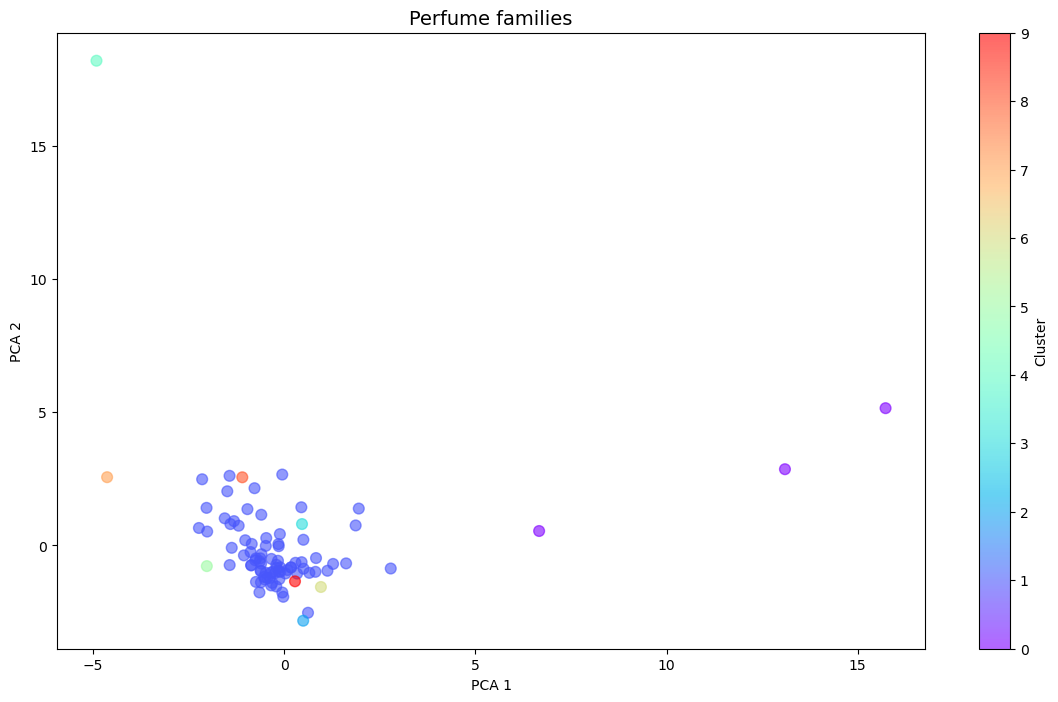

In [127]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(scaled_data)
plt.figure(figsize=(14, 8))
scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=df['cluster'], cmap='rainbow', alpha=0.6, s=60)
plt.title('Perfume families', fontsize=14)
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.colorbar(label='Cluster')

## Add perfume names on the plot
# for i, name in enumerate(df['perfume_name']):
#     plt.text(reduced[i, 0]+0.1, reduced[i, 1]+0.1, name, fontsize=8, alpha=0.8)

# plt.tight_layout()
# plt.show()

In [125]:
cluster_summary = df.groupby('cluster')[['price', 'customer rating']].mean()
display(cluster_summary)

# The most common notes per cluster
for i in range(10):
    cluster_notes = df[df['cluster'] == i]['all_notes'].explode().value_counts().head(10)
    print(f"\nTop notes in Cluster {i}:\n", cluster_notes)

,price,customer rating
cluster,,
0,47.439748,1.666667
1,88.178409,4.310127
2,124.880000,0.000000
3,29.200000,4.600000
4,57.670000,4.600000
5,85.759245,4.800000
6,85.759245,4.800000
7,77.710000,4.800000
8,29.790000,4.600000



Top notes in Cluster 0:
 all_notes
tonka bean    3
vanilla       3
cinnamon      3
sweet         3
praline       2
amber wood    2
benzoin       2
spicy         2
bergamot      1
ginger        1
Name: count, dtype: int64

Top notes in Cluster 1:
 all_notes
floral        47
vanilla       39
jasmine       32
musk          24
bergamot      21
patchouli     21
sandalwood    14
rose          14
amber         13
cedar         12
Name: count, dtype: int64

Top notes in Cluster 2:
 all_notes
cassis          1
rum             1
vanilla         1
long-lasting    1
Name: count, dtype: int64

Top notes in Cluster 3:
 all_notes
bergamot         1
passion fruit    1
reseda           1
chocolate        1
orchid           1
vanilla          1
cedar            1
musk             1
wood             1
floral           1
Name: count, dtype: int64

Top notes in Cluster 4:
 all_notes
freesia        1
rose           1
sandalwood     1
patchouli      1
musk           1
heliotrope     1
amber          1
viole

**Cluster analysis**

We can observe the top 10 most popular notes for each cluster. Just to show the example how clusters could be interpreted, we take only 3 of them. Starting with Cluster 1, this group features the most popular notes: floral, vanilla, jasmine, musk, patchouli, bergamot, sandalwood, oriental, rose, and vetiver. The average price is £88.96, with an average rating of 4.31.
We can label this cluster Luxurious Floral-Orientals, as it includes many well-known designer and premium fragrances. It's characterized by:

- Floral heart notes: jasmine, rose
- Sweet and warm base notes: vanilla, musk, patchouli, sandalwood
- An "oriental" character, indicating spicy-sweet complexity — often incorporating amber, resins, or warm spices

This cluster represents sensual, rich, and often bold fragrances, typically found in the signature scent section of luxury boutiques.

Taking Cluster 9, the dominant notes are: amber, bergamot, saffron, oud, rose, brown sugar, musr and oakmoss. The average price is £119.15, with an average rating of 4.30. Though this cluster contains only one or two perfumes, their note composition is particularly rich and niche. It’s filled with warm spices, gourmand sweetness, and resinous accords. The presence of ingredients like benzoin, myrrh, and tonka bean signals a bold, exotic, and enveloping fragrance, typically worn in the evening or during cooler seasons.
This profile is especially common in Arabic perfumery or niche French houses, making this a "Niche Spicy Gourmand" cluster.

Turning to Cluster 8, the most common notes are: bergamot, freesia, rose, tea, violet, amber, moss, musk, and citrusy. These notes are generally fresh, airy, and natural. The average price of perfumes in this cluster is £29.79, and the average customer rating is 4.60. This cluster is clearly defined by clean, green-floral, and breezy accords. The combination of tea, violet, freesia, and bergamot points to a fresh and delicate scent profile, often found in:

- Minimalist or casual daytime fragrances
- Perfumes with a “green tea” or “dewy garden” vibe
- Unisex or subtle feminine scents

These perfumes may be unisex and more affordable for a younger target audience, as their average price is four times lower compared to the perfumes in Cluster 9.

**How can this information be useful?** 

- Identify customer profiles based on fragrance preferences (e.g., fresh vs. gourmand vs. floral)
- Match customers to perfumes by linking their preferences to clusters with similar note compositions
- Understand market segmentation, including how price and rating vary across scent profiles
- Guide product recommendations or marketing strategies by targeting clusters associated with specific moods, seasons, or budgets

By understanding which perfumes belong to which cluster — and how their notes, price, and customer ratings compare — we can better tailor offerings to different segments of the fragrance market.